In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

## Load data

In [3]:
with open('data/starships.geojson') as f:
    data = json.load(f)

## Drop useless information

### Extract from data

In [4]:
data = data['features']
data = pd.DataFrame(data)

In [5]:
data.head()

,type,properties,geometry
0,Feature,"{'id': 2524742, 'level1': 'Spaceship', 'level2...","{'type': 'Point', 'coordinates': [-19.94941450..."
1,Feature,"{'id': 2525762, 'level1': 'Spaceship', 'level2...","{'type': 'Point', 'coordinates': [-19.94889609..."
2,Feature,"{'id': 2524782, 'level1': 'Spaceship', 'level2...","{'type': 'Point', 'coordinates': [-19.94730510..."
3,Feature,"{'id': 2524782, 'level1': 'Spaceship', 'level2...","{'type': 'Point', 'coordinates': [-19.94790694..."
4,Feature,"{'id': 2524742, 'level1': 'Spaceship', 'level2...","{'type': 'Point', 'coordinates': [-19.94946217..."


In [6]:
data.head()

,type,properties,geometry
0,Feature,"{'id': 2524742, 'level1': 'Spaceship', 'level2...","{'type': 'Point', 'coordinates': [-19.94941450..."
1,Feature,"{'id': 2525762, 'level1': 'Spaceship', 'level2...","{'type': 'Point', 'coordinates': [-19.94889609..."
2,Feature,"{'id': 2524782, 'level1': 'Spaceship', 'level2...","{'type': 'Point', 'coordinates': [-19.94730510..."
3,Feature,"{'id': 2524782, 'level1': 'Spaceship', 'level2...","{'type': 'Point', 'coordinates': [-19.94790694..."
4,Feature,"{'id': 2524742, 'level1': 'Spaceship', 'level2...","{'type': 'Point', 'coordinates': [-19.94946217..."


In [7]:
data.shape

(3467, 3)

In [8]:
data['properties'][0]

{'id': 2524742,
 'level1': 'Spaceship',
 'level2': 'Imperial SpaceShuttle',
 'stream_date': '0121/03/20 12:00:00',
 'force_operante': 'Galactic Empire',
 'site_type': ['Spaceport']}

In [9]:
data['geometry'][0]

{'type': 'Point', 'coordinates': [-19.9494145077604, 27.550263020416665]}

### Investigate constants

In [10]:
# Drop constant type column
print(data['type'].nunique())
data.drop('type', axis=1, inplace=True)

1


In [11]:
# Create dataframe prop and geom from data
prop = data['properties']
prop = pd.DataFrame(list(prop))
geom = data['geometry']
geom = pd.DataFrame(list(geom))

In [12]:
# Drop level1
print(prop['level1'].nunique())
prop.drop('level1', axis=1, inplace=True)

1


In [13]:
# Drop force_operante
print(prop['force_operante'].nunique())
prop.drop('force_operante', axis=1, inplace=True)

1


In [14]:
# Drop site_type
print(prop.shape)
print(sum(prop['site_type'].apply(lambda x: x==['Spaceport'])))
prop.drop('site_type', axis=1, inplace=True)

(3467, 4)
3467


- Since these have the same length, the column site_type is constant
- Drop it!

In [15]:
prop

,id,level2,stream_date
0,2524742,Imperial SpaceShuttle,0121/03/20 12:00:00
1,2525762,Imperial SpaceShuttle,0121/03/20 12:00:00
2,2524782,Imperial SpaceShuttle,0121/03/20 12:00:00
3,2524782,Imperial SpaceShuttle,0121/03/20 12:00:00
4,2524742,Imperial SpaceShuttle,0121/03/20 12:00:00
...,...,...,...
3462,3455,Imperial SpaceShuttle,0121/04/28 12:00:00
3463,3456,Imperial SpaceShuttle,0121/03/20 12:00:00
3464,3457,Imperial SpaceShuttle,0121/03/20 12:00:00
3465,3458,Imperial SpaceShuttle,0121/03/20 12:00:00


### Investigate duplicates

In [16]:
idx_dup = prop[prop['id'].duplicated()].index

In [17]:
prop[prop['id'].duplicated()]

,id,level2,stream_date
3,2524782,Imperial SpaceShuttle,0121/03/20 12:00:00
4,2524742,Imperial SpaceShuttle,0121/03/20 12:00:00
6,2524782,Imperial SpaceShuttle,0121/03/20 12:00:00
7,2525762,Imperial SpaceShuttle,0121/03/20 12:00:00


- There are only 4 redundant ids
- These are definitely duplicates, since having the same stream_date
- The problem is: they correspond to different coordinates

In [18]:
geom['type'].nunique()

1

In [19]:
# Drop constant type column
geom.drop('type', axis=1, inplace=True)

In [20]:
geom['lon'] = geom['coordinates'].apply(lambda x: x[0])
geom['lat'] = geom['coordinates'].apply(lambda x: x[1])

In [21]:
geom.drop('coordinates', axis=1, inplace=True)
coordinates = geom

In [22]:
coordinates.iloc[idx_dup]

,lon,lat
3,-19.947907,27.550382
4,-19.949462,27.550728
6,-19.947955,27.550847
7,-19.948944,27.550770


- The duplicated spaceship is indeed at different places at the same time
- Since the number of rows (4) is not significant compared to the whole dataset (3467), let's drop these records

In [23]:
# Drop duplicated rows
prop.drop(idx_dup, axis=0, inplace=True)
coordinates.drop(idx_dup, axis=0, inplace=True)

- Id is now unique

## Merge dataframes

In [24]:
# Concat dataframes
data = pd.concat([prop, geom], axis=1)

In [25]:
# Use id as index (and drop it from the columns)
data.set_index('id', drop=True, inplace=True)

In [26]:
# Control id is unique
sum(data.index.duplicated())

0

In [27]:
data

,level2,stream_date,lon,lat
id,,,,
2524742,Imperial SpaceShuttle,0121/03/20 12:00:00,-19.949415,27.550263
2525762,Imperial SpaceShuttle,0121/03/20 12:00:00,-19.948896,27.550305
2524782,Imperial SpaceShuttle,0121/03/20 12:00:00,-19.947305,27.550418
2524752,Imperial SpaceShuttle,0121/03/20 12:00:00,-19.948473,27.550805
1,TIE Fighter,0118/05/07 12:00:00,-19.950145,27.552059
...,...,...,...,...
3455,Imperial SpaceShuttle,0121/04/28 12:00:00,-19.923158,27.523213
3456,Imperial SpaceShuttle,0121/03/20 12:00:00,-19.916802,27.515392
3457,Imperial SpaceShuttle,0121/03/20 12:00:00,-19.948425,27.550340


## To continue

In [28]:
# Investigate the number of snapshots
data['stream_date'].nunique()

74

### Inspect stream_date

In [29]:
# First 2 digits
dt_2 = data['stream_date'].apply(lambda x: x[:2])
dt_2.nunique()

1

- The first 2 digits are constants, it ca be deleted safely

In [30]:
data['stream_date'] = data['stream_date'].apply(lambda x: x[2:])

In [31]:
data['stream_date']

id
2524742    21/03/20 12:00:00
2525762    21/03/20 12:00:00
2524782    21/03/20 12:00:00
2524752    21/03/20 12:00:00
1          18/05/07 12:00:00
                 ...        
3455       21/04/28 12:00:00
3456       21/03/20 12:00:00
3457       21/03/20 12:00:00
3458       21/03/20 12:00:00
3459       21/03/20 12:00:00
Name: stream_date, Length: 3463, dtype: object

In [32]:
# Extract and cast as datetime
# It automatically picked %d/%m/%y, but was wrong (thanks to long investigation)!
dt = pd.to_datetime(data['stream_date'], format='%y/%m/%d %H:%M:%S')

In [33]:
dt.sort_values()

id
29     2018-05-07 12:00:00
23     2018-05-07 12:00:00
24     2018-05-07 12:00:00
25     2018-05-07 12:00:00
26     2018-05-07 12:00:00
               ...        
3423   2021-04-28 12:00:00
3424   2021-04-28 12:00:00
3425   2021-04-28 12:00:00
3410   2021-04-28 12:00:00
3414   2021-04-28 12:00:00
Name: stream_date, Length: 3463, dtype: datetime64[ns]

In [34]:
year = dt.apply(lambda x: x.year)

In [35]:
# 29 different years
year.nunique()

4

Text(0.5, 1.0, 'Year')

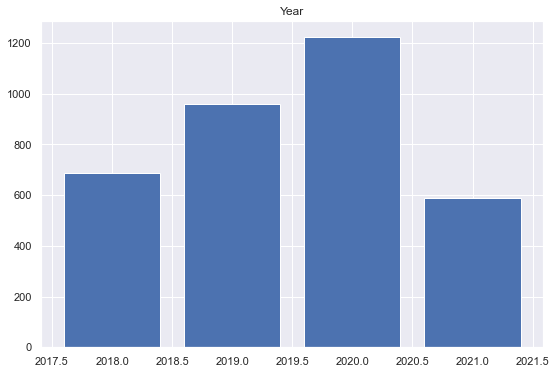

In [36]:
plt.figure(figsize=(9, 6))
year_counts = year.value_counts()
plt.bar(year_counts.index, year_counts.values)
plt.title('Year')

- The date parsing seems to have been done properly
- Use the casted datetime as stream_date field

In [37]:
# Inspect hours, mintues, seconds
print(dt.apply(lambda x: x.hour).nunique())
print(dt.apply(lambda x: x.minute).nunique())
print(dt.apply(lambda x: x.second).nunique())

1
1
1


- Hours, minutes and seconds are irrelevant (constant)

In [38]:
data['stream_date'] = dt

In [39]:
data.sort_values('id', inplace=True)

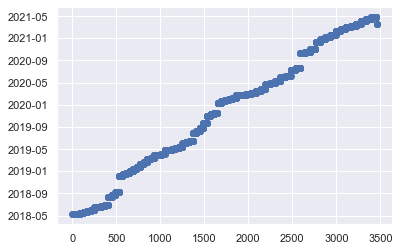

In [40]:
plt.scatter(data.index[:-4], data['stream_date'].iloc[:-4])

- id is now coherent with stream_date

In [43]:
# Rename columns
data.rename(columns={'stream_date': 'date'}, inplace=True)
data.rename(columns={'level2': 'ship_type'}, inplace=True)
data

,ship_type,date,lon,lat
id,,,,
1,TIE Fighter,2018-05-07 12:00:00,-19.950145,27.552059
2,TIE bomber,2018-05-07 12:00:00,-19.925915,27.527897
3,TIE bomber,2018-05-07 12:00:00,-19.927374,27.527464
4,TIE Fighter,2018-05-07 12:00:00,-19.915460,27.516342
5,TIE Fighter,2018-05-07 12:00:00,-19.948334,27.557954
...,...,...,...,...
3459,Imperial SpaceShuttle,2021-03-20 12:00:00,-19.916284,27.515434
2524742,Imperial SpaceShuttle,2021-03-20 12:00:00,-19.949415,27.550263
2524752,Imperial SpaceShuttle,2021-03-20 12:00:00,-19.948473,27.550805


In [42]:
data.to_csv('data/starships_clean.csv')